In [1]:
import pandas as pd
import numpy as np

## Data analysis and transformation

In [30]:
data = pd.read_csv("data.zip", index_col='date', parse_dates=['date'])
data.head()

,ticker,last,volume
date,,,
2013-01-04,1332 JT,169.0987,1464100
2013-01-07,1332 JT,166.3266,1783500
2013-01-08,1332 JT,166.3266,1759800
2013-01-09,1332 JT,165.4026,767800
2013-01-10,1332 JT,167.2507,1503100


In [31]:
prices = data.pivot_table(index=['date'],columns=['ticker'], values=['last'] )

In [109]:
returns = prices.pct_change()
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
print(returns.shape)
returns.columns = returns.columns.get_level_values(1)

(2005, 248)


# Alpha research

We try a simple idea if PCA factors can explain the returns of each ticker and identify if a stock is under or over valued.

In [143]:
from sklearn.decomposition import PCA
from sklearn.linear_model import MultiTaskLassoCV

In [325]:
pca = PCA(n_components=10) # needs more time to identify proper number of factors

In [326]:
insample = 500 # use first 250 days as in-sample data. Can use more but lack of time.

predictions = pd.DataFrame()
# could have done rolling apply but time constraints. Will revise in next iteration.
for i in range(250, insample):
    R = returns.iloc[i-250:i+1] # since i+1 is not inclusive
    R = R.dropna(axis=1, how='all')
    R = R.dropna(axis=0, how='all')
    R = R.fillna(0)
    f = pca.fit_transform(R)
    model = MultiTaskLassoCV(cv=3, random_state=0).fit(f, R) # used only 3 cv due to time constraints. Also can test fit.
    pred = model.predict(f[-1:]) # forecast last day return using fitted model
    df = pd.DataFrame(pred - R.values[-1], columns=R.columns, index=[returns.index[i]]) # undervalued/overvalued prediction
    predictions = pd.concat([predictions, df])
    if i % 25 == 0:
        print("iterations: ", i)

iterations:  250
iterations:  275
iterations:  300
iterations:  325
iterations:  350
iterations:  375
iterations:  400
iterations:  425
iterations:  450
iterations:  475


In [347]:
from scipy.stats import spearmanr

forecasts = predictions.fillna(0).shift(1).dropna() # shift predictions by 1 day
futureReturns = returns.loc[forecasts.index, forecasts.columns].fillna(0)
spearmanr(forecasts.values, futureReturns.values, axis=None) # needs more hypothesis tests (lack of time)

SpearmanrResult(correlation=0.0071569046185267415, pvalue=0.08745341176522778)

# Insample Backtest

In [385]:
weights = forecasts.apply(lambda x: x / x.abs().sum(), axis=1) 
N = weights.shape[1]
weights = weights.clip(lower=-1.5/N, upper=1.5/N, axis=1) # winsorize
weights = weights.apply(lambda x: x / x.abs().sum(), axis=1) 

# also select only top and bottom N stocks

In [386]:
ticker_returns = weights.multiply(futureReturns)

In [387]:
portfolio_returns = ticker_returns.sum(axis=1)

<AxesSubplot:>

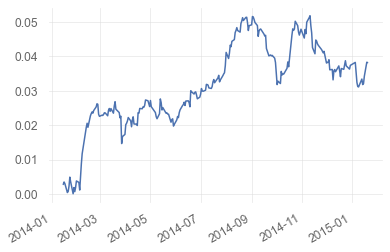

In [388]:
portfolio_returns.cumsum(axis=0).plot()

In [389]:
risk_reward_ratio = portfolio_returns.mean() * 250.0 / (portfolio_returns.std() * np.sqrt(250))
print("crude risk reward: ", risk_reward_ratio)

crude risk reward:  1.3625758874628986


## Alpha Decay

<AxesSubplot:>

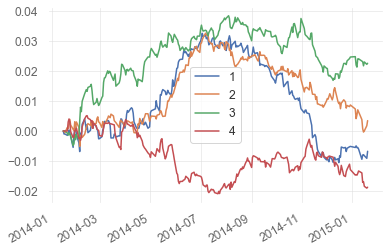

In [390]:
shifted_returns = pd.DataFrame()

for i in range(1, 5):
    shifted_returns[str(i)] = weights.shift(i).fillna(0).multiply(futureReturns).sum(axis=1).cumsum(axis=0)
    
shifted_returns.plot()

## Out of sample backtest

In [374]:
# need more time to run this on larger dataset